In [18]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) already exists in sys.path


In [19]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

In [20]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, test_df = data_loader.load_and_preprocess_data("1d", 0.5, 1)

Removed 24 outliers from 1002 observations. Percentage: 2.40%


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df_split['mood'].max() + 1

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-19 20:35:30,646] A new study created in memory with name: no-name-35785fbf-9679-4b16-b1e5-397513b085ea
[I 2025-04-19 20:35:30,883] Trial 0 finished with value: 0.18061966129711696 and parameters: {'hidden_dim': 35, 'id_embed_dim': 16, 'lr': 0.00043664068638733534, 'batch_size': 32, 'alpha': 0.06350190659848429}. Best is trial 0 with value: 0.18061966129711696.
[I 2025-04-19 20:35:31,041] Trial 1 finished with value: 0.32705575160514144 and parameters: {'hidden_dim': 34, 'id_embed_dim': 10, 'lr': 0.006204629051974908, 'batch_size': 64, 'alpha': 0.23337506576823397}. Best is trial 0 with value: 0.18061966129711696.
[I 2025-04-19 20:35:31,297] Trial 2 finished with value: 0.16382598720098795 and parameters: {'hidden_dim': 65, 'id_embed_dim': 6, 'lr': 0.002231505613599919, 'batch_size': 32, 'alpha': 0.09964148177403855}. Best is trial 2 with value: 0.16382598720098795.
[I 2025-04-19 20:35:31,528] Trial 3 finished with value: 0.16219086351251244 and parameters: {'hidden_dim': 51,

Best hyperparams: {'hidden_dim': 44, 'id_embed_dim': 12, 'lr': 0.0014597807910030946, 'batch_size': 32, 'alpha': 0.010139163004981126}


In [34]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [ ]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50)

Epoch 1: train loss = 0.1028, val loss = 0.0717
Epoch 2: train loss = 0.0443, val loss = 0.0317
Epoch 3: train loss = 0.0168, val loss = 0.0179
Epoch 4: train loss = 0.0110, val loss = 0.0146
Epoch 5: train loss = 0.0095, val loss = 0.0133
Epoch 6: train loss = 0.0087, val loss = 0.0124
Epoch 7: train loss = 0.0082, val loss = 0.0122
Epoch 8: train loss = 0.0078, val loss = 0.0117
Epoch 9: train loss = 0.0075, val loss = 0.0116
Epoch 10: train loss = 0.0072, val loss = 0.0118
Epoch 11: train loss = 0.0069, val loss = 0.0114
Epoch 12: train loss = 0.0067, val loss = 0.0110
Epoch 13: train loss = 0.0065, val loss = 0.0118
Epoch 14: train loss = 0.0064, val loss = 0.0115
Epoch 15: train loss = 0.0062, val loss = 0.0115
Epoch 16: train loss = 0.0061, val loss = 0.0114
Epoch 17: train loss = 0.0059, val loss = 0.0116
Epoch 18: train loss = 0.0057, val loss = 0.0116
Epoch 19: train loss = 0.0056, val loss = 0.0117
Epoch 20: train loss = 0.0056, val loss = 0.0117
Epoch 21: train loss = 0.0055

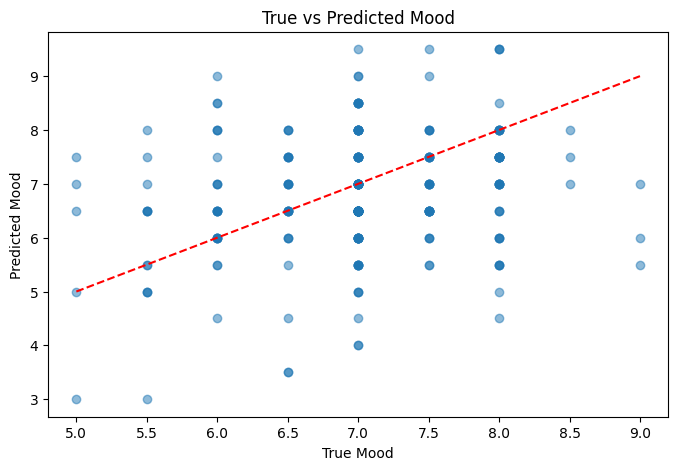

In [32]:
plot_mood_predictions(model, val_loader, device)

In [26]:
from mood_RNN_classifier import get_accuracy_rate
accuracy = get_accuracy_rate(model, val_loader, device)

Accuracy: 0.1729


In [27]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    14
1   AS14.02                    10
2   AS14.03                    13
3   AS14.05                    10
4   AS14.06                    13
5   AS14.07                    12
6   AS14.08                    13
7   AS14.09                    13
8   AS14.12                    15
9   AS14.13                    13
10  AS14.14                    16
11  AS14.15                    12
12  AS14.16                    10
13  AS14.17                    14
14  AS14.19                    11
15  AS14.20                    13
16  AS14.23                    13
17  AS14.24                    14
18  AS14.25                    13
19  AS14.26                    15
20  AS14.27                    11
21  AS14.28                    16
22  AS14.29                    14
23  AS14.30                    13
24  AS14.31                    15
25  AS14.32                    11
26  AS14.33                    13
